# Unsupervised Learning Methods
## Outline 
#### 1. Text similarity: cosine similarity, summary extraction
#### 2. Text clusttering: KNN, visualization with PCA, t-SNE, MDS
#### 3. Build Recommender System

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import plotly.express as px

from scipy.stats import entropy
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS

from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud, STOPWORDS

import re
import string

In [2]:
# download and create the stopwords
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english')) | set(stopwords.words('french')) | set(stopwords.words('italian')) | set(stopwords.words('german')) | set(stopwords.words('portuguese')) | set(stopwords.words('spanish'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ymsc1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# get reviews and perform text vectorization

def get_reviews_vectorized(top_n=-1, ngram_range=(1, 1), max_features=1000):
    df = pd.read_pickle("asset/reviews20221010.pkl")
    df = df.dropna()
    df = df.groupby(['wine ID', 'year']).agg({
        'Review': lambda x : ' '.join(x),
        'name':'unique',
        'country':'unique', 
        'winery': 'unique',
        'price': 'unique',
        'rating': 'unique'
        })
    df.reset_index(inplace=True)
    df = df.astype("string")
    df[['price','rating']] = df[['price','rating']].apply(lambda x: x.str[1:-1])
    df[['name', 'country', 'winery']] = df[['name', 'country', 'winery']].apply(lambda x: x.str[2:-2])
    review_instances = df.Review.replace('\d+'," ", regex=True)
    review_instances = review_instances.replace(r'\n',' ', regex=True)

    vectorizer = TfidfVectorizer(
        max_df=0.5,
        max_features=max_features,
        min_df=10,
        stop_words=stopwords_list,
        ngram_range=ngram_range,
        use_idf=True,
    )
    if top_n >= 0:
        review_instances = review_instances.values[0:top_n]
        df = df[0:top_n]
    else:
        review_instances = review_instances.values


    X = vectorizer.fit_transform(review_instances)

    return (X, vectorizer, review_instances, df)

In [4]:
(X, vectorizer, review_instances, df) = get_reviews_vectorized(-1, (1, 2))

## 1. Text similarity

In [5]:
cosine_similarities = linear_kernel(X, X)

In [6]:
def recommend(name, cosine_similarities = cosine_similarities):
   
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)

    recommend = []
    
    # Find the index of the input
    idx = indices[indices == name].index[0]
    
    # Find the wines with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top 30 wine indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 wines
    for each in top30_indexes:
        recommend.append(list(df_list.index)[each])
    
    # Creating the new data set to show similar wines
    df_new = pd.DataFrame(columns=['country', 'winery', 'price', 'rating'])
    
    # Create the top 30 similar wines with some of their columns
    for each in recommend:
        df_new = df_new.append(pd.DataFrame(df_list[df_list.index == each]))
    
    # Drop the same named wines and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)
    
    print('Top %s wines like %s with similar reviews: ' % (str(len(df_new)), name))
    
    return df_new



def sample():
    select = df.sample(n=1)
    name = select['name'].item()
    print('Select %s ' % name)
    
    return select



def make_wordcloud(text):
    # Generate a word cloud image
    text = text
    wordcloud = WordCloud().generate(text)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [7]:
select = sample()
select

Select Côtes-du-Rhône-Villages 'Plan de Dieu' 2015 


,wine ID,year,Review,name,country,winery,price,rating
865,1143692,2015,Not quite ChdP but close. Dark red with aromas...,Côtes-du-Rhône-Villages 'Plan de Dieu' 2015,France,Château Saint-Jean,30.0921388,3.7


In [8]:
select_name = select.name.item()
recomendation = recommend(select_name)
recomendation

Top 10 wines like Côtes-du-Rhône-Villages 'Plan de Dieu' 2015 with similar reviews: 


,country,winery,price,rating,wine ID,year,Review
Gigondas Les Racines 2017,France,Domaine Les Pallières,34.30699863,4.3,77720,2017,"Tasting in the cellar. A true Gigondas wine, d..."
Cuvée Tradition Gigondas 2017,France,Domaine du Gour de Chaule,29.40599882,4.2,1178837,2017,This is already beautiful and uncompromising. ...
Lirac 2018,France,Château Mont-Redon,31.66865462,4.1,12483,2018,Wonderful raspberry aroma that invites you to ...
Gigondas 2017,France,Château de Saint Cosme,39.20799843,4.1,825166,2017,"Syrah, Grenache. Deep ruby color, aromas of pl..."
La Reine Des Bois Lirac 2018,France,Domaine de la Mordorée,25.48519898,4.,16359,2018,"Good, very different, pear & apricot, toasty f..."
Domaine Grand Veneur Côtes du Rhône Les Champauvins 2020,France,Alain Jaume,13.62477946,4.,1151894,2020,Yes! This is good! Nicely balanced but still s...
Vacqueyras 2016,France,Domaine de la Charbonnière,22.05449912,4.,778758,2016,Very smooth and full. Dark fruit notes with so...
Inopia Rouge 2018,France,Rotem & Mounir Saouma,44.90818714,4.,3856585,2018,Martel Tour des Vins 2022 Pretty mesquite and ...
Côtes du Rhône Villages Terre D'Argile 2020,France,Domaine de la Janasse,16.65359733,4.,75861,2020,"Dark fruit, baking spice, violets, white peppe..."
Coudoulet de Beaucastel Côtes-du-Rhône 2018,France,Château de Beaucastel,26.46539894,4.,1152896,2018,"Black raspberry, black berry, pepper, juicy, w..."


This is the wordcloud of the select wine looks like...


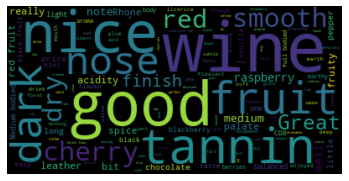

This is the wordcloud of the first recommendation looks like...


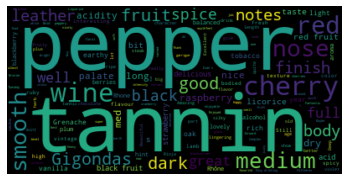

In [9]:
recomendation_1_review = recomendation.iloc[0].Review
select_review = select.Review.item()
print('This is the wordcloud of the select wine looks like...')
make_wordcloud(select_review)
print('This is the wordcloud of the first recommendation looks like...')
make_wordcloud(recomendation_1_review)

## 2. Text clusttering

#### Firstly, try k-means by two categories.

In [10]:
def kmeans_review_k_2():
    result = None
   
    X_ar = X.toarray()
    km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    centroids = km.cluster_centers_
    features = vectorizer.get_feature_names()    
    sorted_centroid_features_idx = centroids.argsort(axis=1)[:,::-1]    
    top10_clust1 = [features[feature_idx] for feature_idx in sorted_centroid_features_idx[0]][:10]
    top10_clust2 = [features[feature_idx] for feature_idx in sorted_centroid_features_idx[1]][:10]
    result = [top10_clust1, top10_clust2]

    return result


kmeans_review_k_2()

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[['bordeaux',
  'merlot',
  'cassis',
  'blackcurrant',
  'syrah',
  'cabernet',
  'malbec',
  'cab',
  'black currant',
  'shiraz'],
 ['lemon',
  'pear',
  'peach',
  'champagne',
  'bubbles',
  'green apple',
  'honey',
  'yellow',
  'grapefruit',
  'chardonnay']]

#### Interesting! It seems the k-means finds two discrete categories, the "red" and the "white"! There are more categories for wines! <br>We want to explore the optimal number of clusters using the elbow method. 

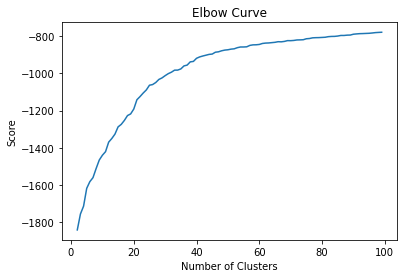

In [11]:
# elbow curve for exploring k values for KNN 
X_ar = X.toarray()
Nc = range(2, 100)
kmeans = [KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, random_state=42) for i in Nc]
kmeans
score = [kmeans[i].fit(X_ar).score(X_ar) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

#### The optimal number of clustters is near 30. We set k=30 for the K-means. <br>Next, we want create labels for each cluster by extracting discrete words in the reviews of each wine.

In [12]:
def compute_distinctive_term_score(T, T_a):
    # First compute information gain.
    IG = entropy(T) - entropy(T_a)

    # if it's high IG, but not for this class, we want to penalize,
    # so flip the IG negative.  We do this because these are terms those whose *absence* is notable,
    # but we don't care about those for purposes of this assignment and so we give them
    # a score that guarantees we won't rank them highly.
    if T_a[0] < T_a[1]:
        score = -IG
    else:
        score = IG
    return score


# create a 1-vs-all two-class matrix for each cluster
def one_vs_all_count_matrix(m, index):
    # row zero is the selected row
    row0 = m[index, :]
    # row one is the other rows summed
    row1 = np.vstack((m[0:index, :], m[index + 1 :, :])).sum(axis=0)

    result = np.vstack((row0, row1))
    return result

In [13]:
def answer_cluster_labeling(n_clusters=7):
    result = None

    X_ar = X.toarray()
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    centroids = km.cluster_centers_
    ig = np.empty([n_clusters, 1000])
    for c in range(n_clusters):
        tc = one_vs_all_count_matrix(centroids, c).sum(axis=1)/one_vs_all_count_matrix(centroids, c).sum(axis=1).sum(axis=0)
        for w in range(1000):
            tw = one_vs_all_count_matrix(centroids, c)[:,w]/one_vs_all_count_matrix(centroids, c).sum(axis=0)[w]
            ig[c,w] = compute_distinctive_term_score(tc, tw)
    features = vectorizer.get_feature_names()    
    sorted_ig_idx = ig.argsort(axis=1)[:,::-1] 
    result = []
    for c in range(n_clusters):
        result.append([features[feature_idx] for feature_idx in sorted_ig_idx[c]][:5])
    return result


answer_cluster_labeling(30)

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[['blanc', 'quince', 'grenache', 'rhone', 'peach pear'],
 ['chocolate oak',
  'italian',
  'cherry chocolate',
  'italy',
  'chocolate vanilla'],
 ['mousse', 'fine bubbles', 'brut', 'biscuit', 'yeasty'],
 ['eucalyptus', 'drop', 'chocolate oak', 'plum blackberry', 'mocha'],
 ['bordeaux', 'second wine', 'petit verdot', 'verdot', 'bordeaux blend'],
 ['tempranillo',
  'spanish',
  'vanilla leather',
  'leather vanilla',
  'vanilla tobacco'],
 ['rhône', 'rhone', 'olive', 'olives', 'deep purple'],
 ['natural',
  'cru',
  'strawberry cherry',
  'pomegranate',
  'raspberry strawberry'],
 ['saline', 'pear lemon', 'white wine', 'pear apple', 'salt'],
 ['verdot', 'petit verdot', 'inky', 'bordeaux blend', 'final'],
 ['cab franc', 'franc', 'cabernet franc', 'cabernet', 'cf'],
 ['bubbly', 'brut', 'fine bubbles', 'bubbles', 'mousse'],
 ['burgundy',
  'strawberry cherry',
  'raspberry strawberry',
  'raspberry cherry',
  'forest floor'],
 ['rose', 'pink', 'salmon', 'strawberries', 'strawberry raspberr

In [14]:
def answer_manifold_a():
    result = None

    # YOUR CODE HERE
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)

    pca = PCA(n_components=2, random_state = 42)
    X_pca = pca.fit_transform(X_ar)
    
    tsne = TSNE(n_components=2, random_state = 42)
    X_tsne = tsne.fit_transform(X_ar)
    
    mds = MDS(n_components=2, random_state = 42)
    X_mds = mds.fit_transform(X_ar)

    result = (X_pca, X_tsne, X_mds)
    return result

X_pca, X_tsne, X_mds = answer_manifold_a()

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


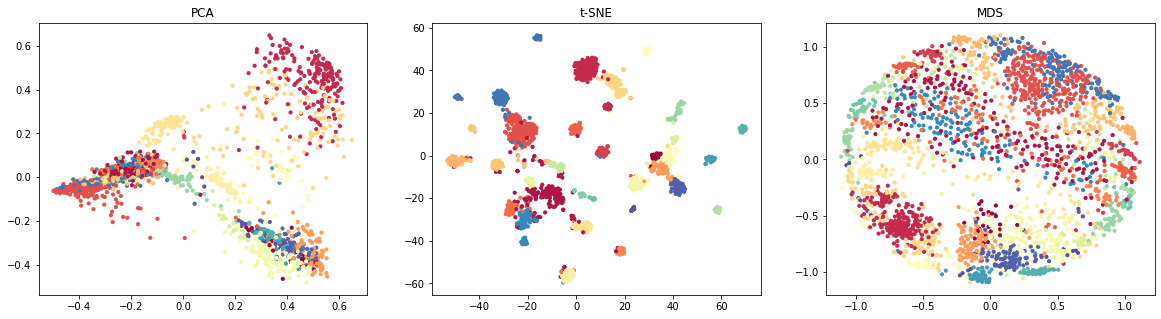

In [15]:
def plot_manifolds():
    colors = cm.Spectral(np.linspace(0, 1, 30))
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    
    axes[0].scatter(X_pca[:, 0], X_pca[:, 1], s=10, color=colors[y])
    axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, color=colors[y])
    axes[2].scatter(X_mds[:, 0], X_mds[:, 1], s=10, color=colors[y])

    axes[0].set_title("PCA")
    axes[1].set_title("t-SNE")
    axes[2].set_title("MDS")
    plt.show()

plot_manifolds()

#### Same visualizations build on Plotly. Enjoy the interactive experiences!

In [16]:
def scatterplot_by_plotly(X, manifolds, title):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    labels = [', '.join(wd) for wd in np.array(answer_cluster_labeling(30))[y]] 
    df_manifolds = pd.DataFrame(manifolds, columns=['x', 'y'])
    df_manifolds['labels'] = labels
    df_plot = pd.concat([df_manifolds, df], axis=1)


    fig = px.scatter(
    df_plot, x='x', y='y',
    color='labels', title=title, 
    hover_data=['name', 'country', 'winery', 'price', 'rating']
    )
    fig.write_html("plotly/%s.html" % title)
    fig.show()

In [17]:
scatterplot_by_plotly(X, X_pca, "PCA")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
scatterplot_by_plotly(X, X_tsne, "t-SNE")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [19]:
scatterplot_by_plotly(X, X_mds, "MDS")

c:\Users\ymsc1\anaconda3\envs\Data Science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



## 3. Build Recommender System

In [20]:
def recommend_knn(name):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    labels = [', '.join(wd) for wd in np.array(answer_cluster_labeling(30))[y]] 
    df_knn = df.copy()
    df_knn['labels'] = labels

    select_label = df_knn[df_knn.name == name].sample(n=1)['labels']
    df_new = df_knn[df_knn.labels == select_label]
    
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)
    
    print('Top %s wines like %s with similar reviews: ' % (str(len(df_new)), name))
    
    return df_new

In [21]:
def get_mean_vector(wine_list):
    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)
    
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)
    vectors = []
    
    for wine in wine_list:
        idx = indices[indices == wine].index[0]
        vector = km.transform(X_ar[idx].reshape(1, -1))
        vectors.append(vector)  
    
    song_matrix = np.array(list(vectors))
    return np.mean(song_matrix, axis=0)




def recommend_knn(wine_list):
    df_list = df.set_index('name')
    indices = pd.Series(df_list.index)

    recommend = []

    X_ar = X.toarray()
    km = KMeans(n_clusters=30, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X_ar)
    y = km.fit_predict(X_ar)

    # Find the wines with a similar cosine-sim value and order them from bigges number
    wine_center = get_mean_vector(wine_list).reshape(1, -1)
    wine_data = km.transform(X_ar)

    distances = cdist(wine_center, wine_data, 'cosine')

    # Extract top 30 wine indexes with a similar cosine-sim value
    top30_indexes = list(np.argsort(distances)[:, :30][0])


    # Names of the top 30 wines
    for each in top30_indexes:
        recommend.append(list(df_list.index)[each])

    # Creating the new data set to show similar wines
    df_new = pd.DataFrame(columns=['country', 'winery', 'price', 'rating'])

    # Create the top 30 similar wines with some of their columns
    for each in recommend:
        df_new = df_new.append(pd.DataFrame(df_list[df_list.index == each]))

    # Drop the same named wines and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['country', 'winery', 'price', 'rating'], keep=False)
    df_new = df_new.sort_values(by='rating', ascending=False).head(10)

    print('Top wines like with similar reviews according to the user list: ')

    return df_new




def sample_list(n=5):
    select = df.sample(n)
    for i in range(n):
        name = select.name.iloc[i]
        print('Select %s ' % name)
    
    return select

In [22]:
user_sample = sample_list(5)
user_list = user_sample.name.tolist()
user_sample

Select Rosso della Gobba 2018 
Select Rosato Toscana 2018 
Select Les Tourelles de Longueville Pauillac 2015 
Select Clairette du Languedoc Adissan Art de Vivre 2019 
Select Riesling Trocken-Sec 2018 


,wine ID,year,Review,name,country,winery,price,rating
1875,2141375,2018,"Very harmonious, medium to light bodied, full ...",Rosso della Gobba 2018,Italy,Raína,18.52577926,3.8
1994,2676169,2018,"When I love a wine, regardless of pricing, I b...",Rosato Toscana 2018,Italy,Santa Cristina,14.04580661,3.6
798,1135844,2015,Medium ruby opaque one or the darkest so far. ...,Les Tourelles de Longueville Pauillac 2015,France,Château Pichon Baron,48.91197804,4.1
2318,7236298,2019,Summer Friday evening patio and pizza. This w...,Clairette du Languedoc Adissan Art de Vivre 2019,France,Gérard Bertrand,11.46833954,3.9
2294,6663944,2018,Part of Chapoutier Group and unique in offerin...,Riesling Trocken-Sec 2018,Germany,Schieferkopf,15.99750183,3.7


In [23]:
recomendation_list = recommend_knn(user_list)
recomendation_list

Top wines like with similar reviews according to the user list: 


,country,winery,price,rating,wine ID,year,Review
Stella Peach N.V.,Italy,Stella Rosa,12.99,4.3,1364830,N.V.,Talk about an absolutely gorgeous wine! I can ...
Corse Sartène Rouge 2019,France,Castellu di Baricci,26.36737895,4.2,1270941,2019,"Raisin and porty flavours up front, despite th..."
Sivi Pinot Grigio 2018,Italy,Radikon,35.28719859,4.2,1232133,2018,"Nose: light rubber, some honey, mandarin, oran..."
Blanc de Blancs Brut Champagne N.V.,France,Léon Launois,24.49519702,4.2,8106874,N.V.,A Blanc de Blancs with an excellent quality/pr...
Vermouth de Chambéry Dry N.V.,France,Dolin,20.31042832,4.1,1406124,N.V.,Makes a great Manhattan. I used Buffalo Trace ...
Argali Rouge 2019,France,Château Puech-Haut,12.93863948,4.,7371306,2019,👁 bright red color 👃 beautiful aromatic depth...
Stella Pink N.V.,Italy,Stella Rosa,12.99,4.,2006166,N.V.,"Strong red berries flavor, very refreshing, we..."
Vej Bianco Antico 2020,Italy,Podere Pradarolo,22.5445991,4.,1591912,2020,"Peach, apricot, bees wax, orange blossom, oran..."
Selida Gewürztraminer 2017,Italy,Tramin,35.19450403,4.,4382056,2017,"Good wine, typicall Gewürtztraminer taste, hon..."
La Petite Fable Côtes-du-Rhône 2015,France,Laurens Deblaere,17.27090298,4.,5087247,2015,A clear garnet to ruby colour. A really intere...


This is the wordcloud of the user list looks like...


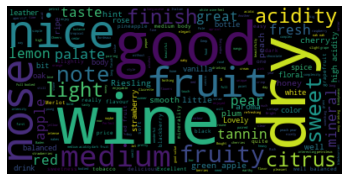

This is the wordcloud of the recommendation list looks like...


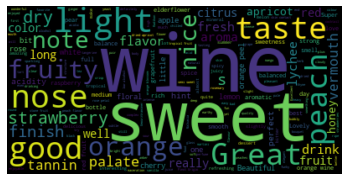

In [24]:
user_sample_1_review = ' '.join(user_sample.Review.tolist())
print('This is the wordcloud of the user list looks like...')
make_wordcloud(user_sample_1_review)
recomendation_1_review = ' '.join(recomendation_list.Review.tolist())
print('This is the wordcloud of the recommendation list looks like...')
make_wordcloud(recomendation_1_review)